# Benchmark and Bounds Tests

The purpose of this notebook is to benchmark all of the single GPU cuML algorithms against their skLearn counterparts, while also providing the ability to find and verify upper bounds. 

This benchmark will persist results into a file so that benchmarking may be continued, in the case of failure. 

Also supported is the ability to draw charts with the results, which should aid in presentations and transparency to end-users. 

## Notebook Credits
### Authorship
Original Author: Corey Nolet 

Last Edit: Corey Nolet, 06/25/2019    
    
### Test System Specs
Test System Hardware: DGX-1 
Test System Software: Ubuntu 16.04  
RAPIDS Version: 0.8.0pre - Conda Install  
Driver: 410.48
CUDA: 10.0  

### Known Working Systems
RAPIDS Versions: 0.8+

In [22]:
import numpy as np
import pandas as pd
import cudf
import os
import time
import pickle
import cuml

import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 40, 20
rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

print(cuml.__version__)

0.7.0+1042.g194333f


In [31]:
# Default parameters

N_JOBS_SKLEARN = -1            # Passed to the n_jobs parameter, indicates number of cpu jobs to run
                               # Note that some sklearn algorithms do not support n_jobs (e.g. PCA), so they run a single job
RERUN_BENCH = True             # Set to true to force re-running even if a result is cached
MAX_BENCH_ROW_COUNTS = -1      # When iterating over many row sizes, only consider first N options (for faster testing, set to -1 for all options)
MAX_BENCH_FEATURE_COUNTS = -1  # When iterating over many feature counts, only consider first N options (for faster testing, set to -1 for all options)

# Benchmark function definitions

### Data loading functions

In [32]:
import gzip

def load_data_mortgage_X(nrows, ncols, cached = '../../../data/mortgage.npy.gz',source='mortgage', dtype = np.float32):
    print("Loading " + str(cached))
    if os.path.exists(cached) and source=='mortgage':
        print('use mortgage data')
        with gzip.open(cached) as f:
            X = np.load(f)
        X = X[np.random.randint(0,X.shape[0]-1,nrows),:ncols]
    else:
        print('use random data')
        X = np.random.random((nrows,ncols)).astype(dtype)
    df = pd.DataFrame({'fea%d'%i:X[:,i] for i in range(X.shape[1])}).fillna(0)
    return df

def load_data_mortgage_Xy(nrows, ncols, dtype = np.float32):
    """
    Generate a dataframe and series based on rows and cols
    """
    X = load_data_mortgage_X(nrows, ncols, dtype = dtype)
    y = load_data_mortgage_X(nrows, 1, dtype = dtype)["fea0"]
    return (X, y)


def load_data_X(nrows, ncols, dtype = np.float32):
    """
    Generate a single dataframe with specified rows and cols
    """
    X = np.random.uniform(-1, 1, (nrows,ncols))
    df = pd.DataFrame({'fea%d'%i:X[:,i].astype(dtype) for i in range(X.shape[1])})
    return df

def load_data_Xy(nrows, ncols, dtype = np.float32):
    """
    Generate a dataframe and series based on rows and cols
    """
    X = load_data_X(nrows, ncols, dtype)
    y = load_data_X(nrows, 1, dtype)["fea0"]
    return (X, y)

def load_data_X_npy(nrows, ncols, dtype=np.float32):
    return np.random.uniform(-1, 1,(nrows, ncols))

def load_data_Xy_npy(nrows, ncols, dtype = np.float32):
    X = load_data_X_npy(nrows, ncols, dtype)
    y = load_data_X_npy(nrows, 1, dtype)
    return (X, y)
    

In [33]:
def pandas_convert(data):
    if isinstance(data, tuple):
        return tuple([pandas_convert(d) for d in data])
    elif isinstance(data, pd.DataFrame):
        return cudf.DataFrame.from_pandas(data)
    elif isinstance(data, pd.Series):
        return cudf.Series.from_pandas(data)
    else:
        raise Exception("Unsupported type %s" % str(type(data)))
        
def no_convert(data):
    if isinstance(data, tuple):
        return tuple([d for d in data])
    elif isinstance(data, np.ndarray):
        return data
    else:
        raise Exception("Unsupported type %s" % str(type(data)))


### Pluggable benchmark function 

In [34]:
class SpeedupBenchmark(object):
    
    def __init__(self, converter = pandas_convert):
        self.name = "speedup"
        self.converter = converter
    
    def __str__(self):
        return "Speedup"
    
    def run(self, algo, rows, dims, data):

        data2 = self.converter(data)
        cu_start = time.time()
        algo.cuml(data2)
        cu_elapsed = time.time() - cu_start
        
        sk_start = time.time()
        algo.sk(data)
        sk_elapsed = time.time() - float(sk_start)

        # Needs to return the calculation and the name given to it.
        return sk_elapsed / float(cu_elapsed)

In [35]:
class BenchmarkRunner(object):
    
    def __init__(self, 
                 benchmarks = [SpeedupBenchmark()],
                 out_filename = "benchmark.pickle",
                 rerun = RERUN_BENCH,
                 n_runs = 3,
                 bench_rows = [2**x for x in range(13, 20)],
                 bench_dims = [64, 128, 256, 512]):

        self.benchmarks = benchmarks
        self.rerun = rerun
        self.n_runs = n_runs
        self.bench_rows = bench_rows[:MAX_BENCH_ROW_COUNTS]
        self.bench_dims = bench_dims[:MAX_BENCH_FEATURE_COUNTS]
        self.out_filename = out_filename        
        
    def load_results(self):
        
        if os.path.exists(self.out_filename):
            print("Loaded previous benchmark results from %s" % (self.out_filename))
            with open(self.out_filename, 'rb') as f:
                return pickle.load(f)
                
        else:
            return {}
        
    def store_results(self, final_results):
        with open(self.out_filename, 'wb') as f:
            pickle.dump(final_results, f)
        
            
    def run(self, algo):
        
        final_results = self.load_results()
        
        for benchmark in self.benchmarks:
            if algo.name in final_results:
                results = final_results[algo.name]
            else:
                results = {}
                final_results[algo.name] = results

            for n_rows in self.bench_rows:
                for n_dims in self.bench_dims:     
                    if (n_rows, n_dims, benchmark.name) not in results or self.rerun:

                        print("Running %s. (nrows=%d, n_dims=%d)" % (str(algo), n_rows, n_dims))

                        data = algo.load_data(n_rows, n_dims)
                        runs = [benchmark.run(algo, n_rows, n_dims, data) for i in range(self.n_runs)]
                        results[(n_rows, n_dims, benchmark.name)] = np.mean(runs)

                        print("Benchmark for %s = %f" % (str((n_rows, n_dims, benchmark.name)), 
                                                         results[(n_rows, n_dims, benchmark.name)]))
                        
                        self.store_results(final_results)

                            
    def chart(self, algo, title = "cuML vs SKLearn"):
        
        for benchmark in self.benchmarks:
        
            results = self.load_results()[algo.name]

            final = {}

            plts = []
            for dim in self.bench_dims:
                data = {k: v for (k, v) in results.items() if dim == k[1]}

                if len(data) > 0:
                    data = [(k[0], v) for k, v in data.items()]
                    data.sort(key = lambda x: x[0])

                    final[dim] = list(map(lambda x: x[1], data))

                    keys = list(map(lambda x: np.log2(x[0]), data))
                line = plt.plot(keys, final[dim], label = str(dim), linewidth = 3,  marker = 'o', markersize = 7)

                plts.append(line[0])
            leg = plt.legend(handles = plts, fontsize = 30)
            leg.set_title("Dimensions", prop = {'size':'x-large'})    
            plt.title("%s %s: %s" % (algo, benchmark, title), fontsize = 30)

            plt.ylabel(str(benchmark), fontsize = 20)
            plt.xlabel("Training Examples (2^x)", fontsize = 40)

            plt.tick_params(axis='both', which='major', labelsize=15)
            plt.tick_params(axis='both', which='minor', labelsize=15)

            plt.show()

In [36]:
class BaseAlgorithm(object):
    def __init__(self, load_data = load_data_X):
        self.load_data = load_data

# Benchmarks and Results

### Nearest Neighbors

In [23]:
from sklearn.neighbors import NearestNeighbors
from cuml.neighbors import NearestNeighbors as cumlNN

class NearestNeighborsAlgo(BaseAlgorithm):
    
    def __init__(self, n_neighbors = 1024, load_data = load_data_X):
        self.n_neighbors = n_neighbors
        self.name = "nearest_neighbors"

        BaseAlgorithm.__init__(self, load_data)
        
    def __str__(self):
        return "NearestNeighbors"
        
    def sk(self, X):
        knn_sk = NearestNeighbors(n_neighbors = self.n_neighbors, algorithm = 'brute', n_jobs=N_JOBS_SKLEARN)
        knn_sk.fit(X)
        D_sk,I_sk = knn_sk.kneighbors(X[0:100])

    def cuml(self, X):
        knn_cuml = cumlNN(n_neighbors = self.n_neighbors)
        knn_cuml.fit(X)
        D_cuml,I_cuml = knn_cuml.kneighbors(X[0:100])


In [24]:
runner = BenchmarkRunner(benchmarks = [SpeedupBenchmark(no_convert)], bench_rows = [2**x for x in range(11, 24)])
runner.run(NearestNeighborsAlgo(load_data = load_data_X_npy))

Loaded previous benchmark results from benchmark.pickle
Running NearestNeighbors. (nrows=1048576, n_dims=64)
Benchmark for (1048576, 64, 'speedup') = 6.181410
Running NearestNeighbors. (nrows=1048576, n_dims=128)
Benchmark for (1048576, 128, 'speedup') = 3.777027
Running NearestNeighbors. (nrows=1048576, n_dims=256)
Benchmark for (1048576, 256, 'speedup') = 2.637395
Running NearestNeighbors. (nrows=2097152, n_dims=64)
Benchmark for (2097152, 64, 'speedup') = 8.866336
Running NearestNeighbors. (nrows=2097152, n_dims=128)
Benchmark for (2097152, 128, 'speedup') = 6.115579
Running NearestNeighbors. (nrows=2097152, n_dims=256)
Benchmark for (2097152, 256, 'speedup') = 3.425108
Running NearestNeighbors. (nrows=4194304, n_dims=64)
Benchmark for (4194304, 64, 'speedup') = 10.130537
Running NearestNeighbors. (nrows=4194304, n_dims=128)
Benchmark for (4194304, 128, 'speedup') = 6.313551
Running NearestNeighbors. (nrows=4194304, n_dims=256)
Benchmark for (4194304, 256, 'speedup') = 3.446205


In [ ]:
runner = BenchmarkRunner()
runner.chart(NearestNeighborsAlgo())

### DBSCAN

In [25]:
from sklearn.cluster import DBSCAN as skDBSCAN
from cuml import DBSCAN as cumlDBSCAN

class DBSCANAlgo(BaseAlgorithm):
    
    def __init__(self, eps = 3, min_samples = 2):
        self.name = "dbscan"
        self.eps = 3
        self.min_samples = 2
        BaseAlgorithm.__init__(self)
        
    def __str__(self):
        return "DBSCAN"

    def sk(self, X):
        clustering_sk = skDBSCAN(eps = self.eps, min_samples = self.min_samples, algorithm = "brute", n_jobs=N_JOBS_SKLEARN)
        clustering_sk.fit(X)

    def cuml(self, X):
        clustering_cuml = cumlDBSCAN(eps = self.eps, min_samples = self.min_samples)
        clustering_cuml.fit(X)

In [26]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(10, 17)])
runner.run(DBSCANAlgo())

Loaded previous benchmark results from benchmark.pickle
Running DBSCAN. (nrows=1024, n_dims=64)
Benchmark for (1024, 64, 'speedup') = 0.496923
Running DBSCAN. (nrows=1024, n_dims=128)
Benchmark for (1024, 128, 'speedup') = 0.409368
Running DBSCAN. (nrows=1024, n_dims=256)
Benchmark for (1024, 256, 'speedup') = 0.548173
Running DBSCAN. (nrows=2048, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (2048, 64, 'speedup') = 0.800954
Running DBSCAN. (nrows=2048, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (2048, 128, 'speedup') = 0.532540
Running DBSCAN. (nrows=2048, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (2048, 256, 'speedup') = 0.769082
Running DBSCAN. (nrows=4096, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (4096, 64, 'speedup') = 1.876130
Running DBSCAN. (nrows=4096, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (4096, 128, 'speedup') = 1.523047
Running DBSCAN. (nrows=4096, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (4096, 256, 'speedup') = 1.094747
Running DBSCAN. (nrows=8192, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (8192, 64, 'speedup') = 7.368071
Running DBSCAN. (nrows=8192, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (8192, 128, 'speedup') = 5.129010
Running DBSCAN. (nrows=8192, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]


Benchmark for (8192, 256, 'speedup') = 4.086094
Running DBSCAN. (nrows=16384, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sk

Benchmark for (16384, 64, 'speedup') = 25.065906
Running DBSCAN. (nrows=16384, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sk

Benchmark for (16384, 128, 'speedup') = 22.121955
Running DBSCAN. (nrows=16384, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sk

Benchmark for (16384, 256, 'speedup') = 16.192003
Running DBSCAN. (nrows=32768, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sk

Benchmark for (32768, 64, 'speedup') = 88.013009
Running DBSCAN. (nrows=32768, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sk

Benchmark for (32768, 128, 'speedup') = 68.770075
Running DBSCAN. (nrows=32768, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sklearn/neighbors/base.py:606: RuntimeWarning: invalid value encountered in less_equal
  neigh_ind = [np.where(d <= radius)[0] for d in dist]
/raid/cjnolet/cuml5/lib/python3.7/site-packages/sk

Benchmark for (32768, 256, 'speedup') = 52.392020


Loaded previous benchmark results from benchmark.pickle


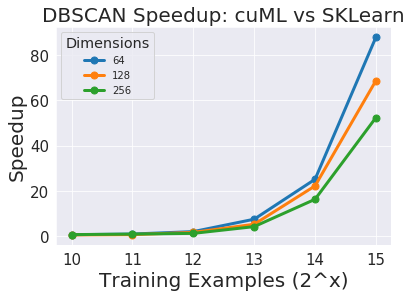

In [27]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(10, 17)])
runner.chart(DBSCANAlgo())

### UMAP

In [46]:
from umap import UMAP as skUMAP
from cuml.manifold.umap import UMAP as cumlUMAP

class UMAPAlgo(BaseAlgorithm):
    
    def __init__(self, n_neighbors = 5, n_epochs = 500):
        self.name = "umap"
        self.n_neighbors = n_neighbors
        self.n_epochs = n_epochs
        BaseAlgorithm.__init__(self)
        
    def __str__(self):
        return "UMAP"

    def sk(self, X):
        clustering_sk = skUMAP(n_neighbors = self.n_neighbors, n_epochs = self.n_epochs)
        clustering_sk.fit(X)

    def cuml(self, X):
        clustering_cuml = cumlUMAP(n_neighbors = self.n_neighbors, n_epochs = self.n_epochs)
        clustering_cuml.fit(X)

In [29]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(12, 20)])
runner.run(UMAPAlgo())

Loaded previous benchmark results from benchmark.pickle
Running UMAP. (nrows=4096, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /raid/cjnolet/cuml5/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../cuml5/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7f8ebe162

Benchmark for (4096, 64, 'speedup') = 11.789598
Running UMAP. (nrows=4096, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (4096, 128, 'speedup') = 9.166705
Running UMAP. (nrows=4096, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (4096, 256, 'speedup') = 9.815435
Running UMAP. (nrows=8192, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (8192, 64, 'speedup') = 19.604745
Running UMAP. (nrows=8192, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (8192, 128, 'speedup') = 19.115289
Running UMAP. (nrows=8192, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (8192, 256, 'speedup') = 17.576009
Running UMAP. (nrows=16384, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (16384, 64, 'speedup') = 32.849509
Running UMAP. (nrows=16384, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (16384, 128, 'speedup') = 33.950535
Running UMAP. (nrows=16384, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (16384, 256, 'speedup') = 32.892538
Running UMAP. (nrows=32768, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (32768, 64, 'speedup') = 61.838032
Running UMAP. (nrows=32768, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (32768, 128, 'speedup') = 54.819890
Running UMAP. (nrows=32768, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (32768, 256, 'speedup') = 39.172925
Running UMAP. (nrows=65536, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (65536, 64, 'speedup') = 94.522386
Running UMAP. (nrows=65536, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (65536, 128, 'speedup') = 90.715664
Running UMAP. (nrows=65536, n_dims=256)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (65536, 256, 'speedup') = 106.263817
Running UMAP. (nrows=131072, n_dims=64)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  s

Benchmark for (131072, 64, 'speedup') = 136.116251
Running UMAP. (nrows=131072, n_dims=128)


/raid/cjnolet/cuml5/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../cuml5/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


KeyboardInterrupt: 

Loaded previous benchmark results from benchmark.pickle


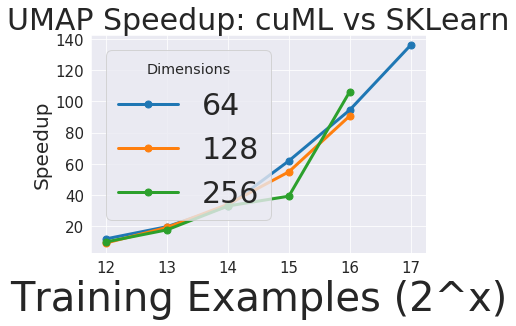

In [47]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(12, 20)])
runner.chart(UMAPAlgo())

### K-means Clustering

In [30]:
from sklearn.cluster import KMeans as skKmeans
from cuml.cluster import KMeans as cumlKmeans

class KMeansAlgo(BaseAlgorithm):
    
    def __init__(self, n_clusters=5):
        self.name = "kmeans"
        self.n_clusters = n_clusters
        BaseAlgorithm.__init__(self, load_data_X_npy)
        
    def __str__(self):
        return "KMeans"

    def sk(self, X):
        clustering_sk = skKmeans(n_clusters=self.n_clusters, n_jobs=N_JOBS_SKLEARN)
        clustering_sk.fit(X)

    def cuml(self, X):
        clustering_cuml = cumlKmeans(n_clusters=self.n_clusters)
        clustering_cuml.fit(X)

In [31]:
runner = BenchmarkRunner(benchmarks = [SpeedupBenchmark(no_convert)], bench_rows = [2**x for x in range(12, 21, 2)])
runner.run(KMeansAlgo())

Loaded previous benchmark results from benchmark.pickle
Running KMeans. (nrows=4096, n_dims=64)
Benchmark for (4096, 64, 'speedup') = 13.030073
Running KMeans. (nrows=4096, n_dims=128)
Benchmark for (4096, 128, 'speedup') = 4.057298
Running KMeans. (nrows=4096, n_dims=256)
Benchmark for (4096, 256, 'speedup') = 2.579118
Running KMeans. (nrows=16384, n_dims=64)
Benchmark for (16384, 64, 'speedup') = 8.404808
Running KMeans. (nrows=16384, n_dims=128)
Benchmark for (16384, 128, 'speedup') = 8.865265
Running KMeans. (nrows=16384, n_dims=256)
Benchmark for (16384, 256, 'speedup') = 8.842293
Running KMeans. (nrows=65536, n_dims=64)
Benchmark for (65536, 64, 'speedup') = 24.669544
Running KMeans. (nrows=65536, n_dims=128)
Benchmark for (65536, 128, 'speedup') = 29.013915
Running KMeans. (nrows=65536, n_dims=256)
Benchmark for (65536, 256, 'speedup') = 30.123571
Running KMeans. (nrows=262144, n_dims=64)
Benchmark for (262144, 64, 'speedup') = 40.359327
Running KMeans. (nrows=262144, n_dims=128

In [ ]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(12, 21, 2)])
runner.chart(KMeansAlgo())

### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression as skLR
from cuml.linear_model import LinearRegression as cumlLR

class LinearRegressionAlgo(BaseAlgorithm):
    def __init__(self):
        BaseAlgorithm.__init__(self, load_data_Xy)
        self.name = "linear_regression"
        
    def __str__(self):
        return "Linear Regression"

    def sk(self, data):
        X, y = data
        clustering_sk = skLR(n_jobs=N_JOBS_SKLEARN)
        clustering_sk.fit(X, y)

    def cuml(self, data):
        X, y = data
        cuml_lr = cumlLR()
        cuml_lr.fit(X, y)

In [33]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(15, 23)])
runner.run(LinearRegressionAlgo())

Loaded previous benchmark results from benchmark.pickle
Running Linear Regression. (nrows=32768, n_dims=64)
Benchmark for (32768, 64, 'speedup') = 0.909373
Running Linear Regression. (nrows=32768, n_dims=128)
Benchmark for (32768, 128, 'speedup') = 0.755692
Running Linear Regression. (nrows=32768, n_dims=256)
Benchmark for (32768, 256, 'speedup') = 0.986067
Running Linear Regression. (nrows=65536, n_dims=64)
Benchmark for (65536, 64, 'speedup') = 1.140851
Running Linear Regression. (nrows=65536, n_dims=128)
Benchmark for (65536, 128, 'speedup') = 1.262066
Running Linear Regression. (nrows=65536, n_dims=256)
Benchmark for (65536, 256, 'speedup') = 2.048063
Running Linear Regression. (nrows=131072, n_dims=64)
Benchmark for (131072, 64, 'speedup') = 1.933056
Running Linear Regression. (nrows=131072, n_dims=128)
Benchmark for (131072, 128, 'speedup') = 2.251759
Running Linear Regression. (nrows=131072, n_dims=256)
Benchmark for (131072, 256, 'speedup') = 3.250359
Running Linear Regression.

In [ ]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(15, 23)])
runner.chart(LinearRegressionAlgo())

### PCA / SVD

In [34]:
from sklearn.decomposition import PCA as skPCA
from cuml import PCA as cumlPCA

class PCAAlgo(BaseAlgorithm):
    
    def __init__(self, n_components = 10, load_data = load_data_mortgage_X):
        self.n_components = 10
        self.name = "pca"
        BaseAlgorithm.__init__(self, load_data = load_data)
        
    def __str__(self):
        return "PCA"

    def sk(self, X):
        skpca = skPCA(n_components = 10)
        skpca.fit(X)

    def cuml(self, X):
        cumlpca = cumlPCA(n_components = 10)
        cumlpca.fit(X)

In [35]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(18, 23)])
runner.run(PCAAlgo())

Loaded previous benchmark results from benchmark.pickle
Running PCA. (nrows=262144, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (262144, 64, 'speedup') = 6.939371
Running PCA. (nrows=262144, n_dims=128)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (262144, 128, 'speedup') = 6.301489
Running PCA. (nrows=262144, n_dims=256)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (262144, 256, 'speedup') = 4.746825
Running PCA. (nrows=524288, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (524288, 64, 'speedup') = 13.008795
Running PCA. (nrows=524288, n_dims=128)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (524288, 128, 'speedup') = 13.381878
Running PCA. (nrows=524288, n_dims=256)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (524288, 256, 'speedup') = 10.466071
Running PCA. (nrows=1048576, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use

In [ ]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(18, 23)])
runner.chart(PCAAlgo())

In [37]:
from sklearn.ensemble import RandomForestClassifier as skRFC
from cuml.ensemble import RandomForestClassifier as cumlRFC

class RandomForestClassifierAlgo(BaseAlgorithm):
    
    def __init__(self, n_estimators = 1000, load_data = load_data_mortgage_Xy):
        self.n_estimators = n_estimators
        self.name = "random_forest_classifier"
        BaseAlgorithm.__init__(self, load_data = load_data)
        
    def __str__(self):
        return "Random Forest Classifier"

    def sk(self, data):
        X, y = data
        skrfc = skRFC(n_jobs = -1, n_estimators = self.n_estimators)
        skrfc.fit(X, y.astype(np.int32))
        
    def cuml(self, data):
        X, y = data
        cumlrfc = cumlRFC(n_estimators = self.n_estimators)
        cumlrfc.fit(X, y.astype(np.int32))

In [ ]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(18, 23)])
runner.run(RandomForestClassifierAlgo())

Loaded previous benchmark results from benchmark.pickle
Running Random Forest Classifier. (nrows=262144, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use random data
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (262144, 64, 'speedup') = 0.378741
Running Random Forest Classifier. (nrows=262144, n_dims=128)
Loading ../../../data/mortgage.npy.gz
use random data
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (262144, 128, 'speedup') = 0.291636
Running Random Forest Classifier. (nrows=262144, n_dims=256)
Loading ../../../data/mortgage.npy.gz
use random data
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (262144, 256, 'speedup') = 0.207838
Running Random Forest Classifier. (nrows=524288, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use random data
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (524288, 64, 'speedup') = 0.506146
Running Random Forest Classifier. (nrows=524288, n_dims=128)
Loading ../

Loaded previous benchmark results from benchmark.pickle


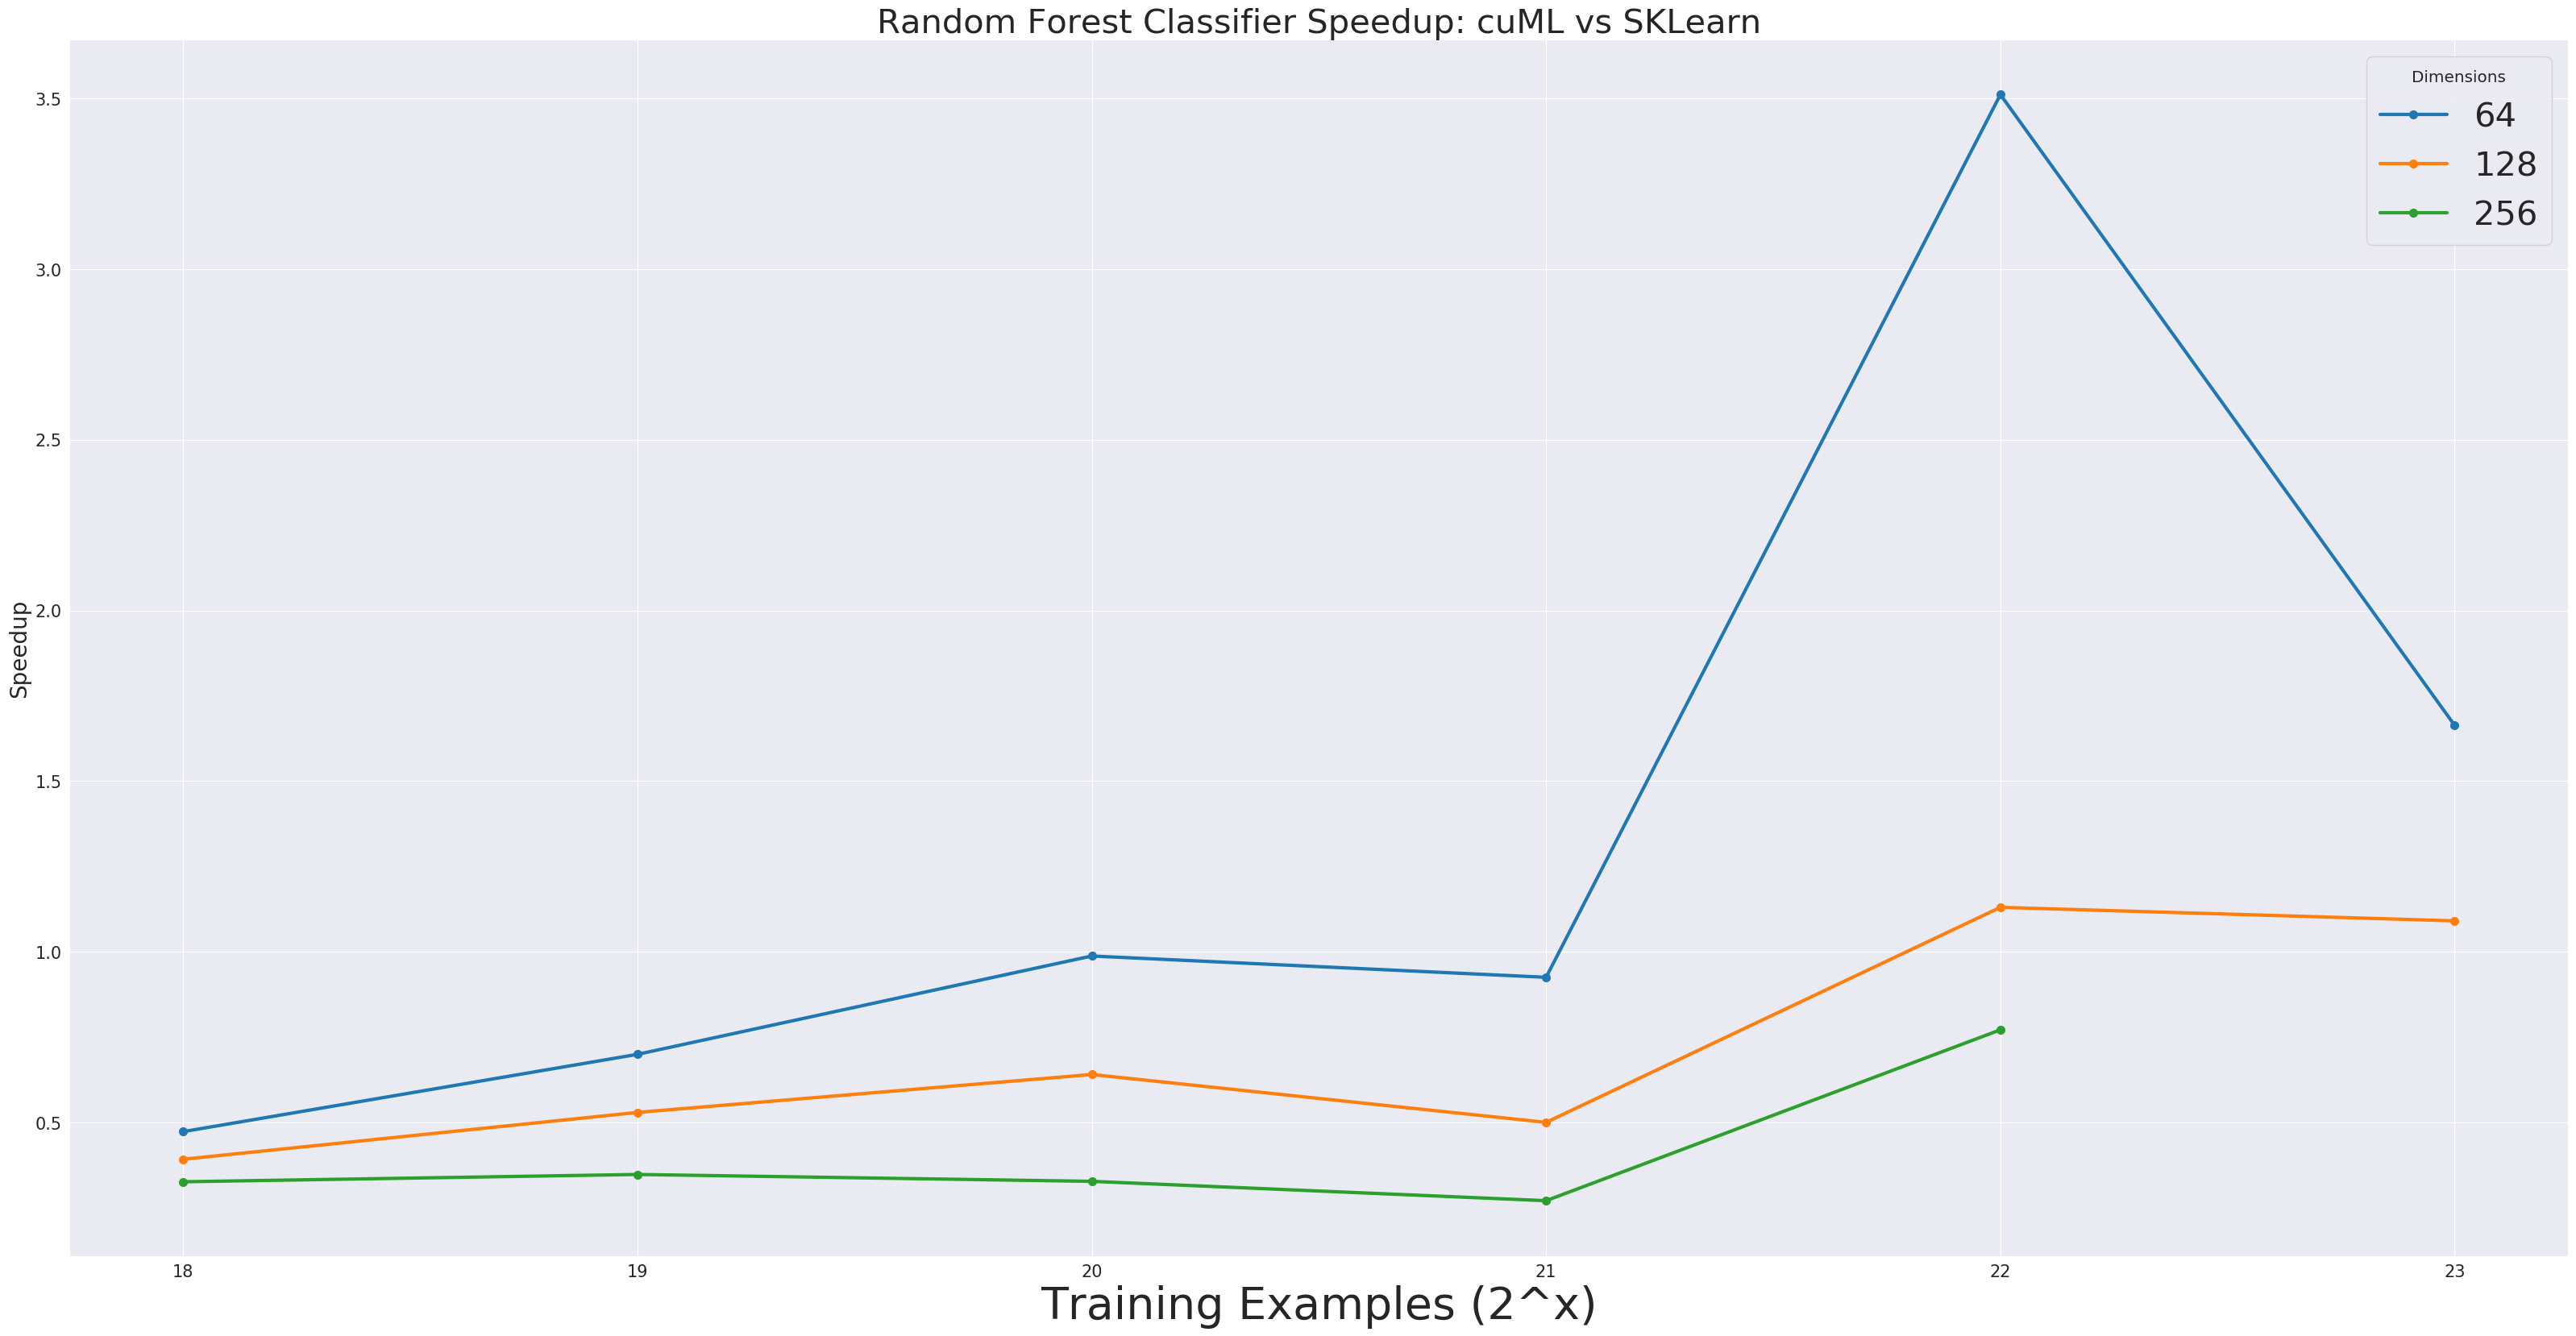

In [21]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(18, 23)])
runner.chart(RandomForestClassifierAlgo())

In [8]:
from sklearn.random_projection import GaussianRandomProjection as skGRP
from cuml.random_projection import GaussianRandomProjection as cumlGRP

class GaussianRandomProjectionAlgo(BaseAlgorithm):
    
    def __init__(self, load_data = load_data_mortgage_X):
        self.name = "gaussian_random_projection"
        BaseAlgorithm.__init__(self, load_data = load_data)
        
    def __str__(self):
        return "Gaussian Random Projection"

    def sk(self, data):
        X = data
        skrfc = skGRP(n_components = 2)
        skrfc.fit(X)
        skrfc.transform(X)

    def cuml(self, data):
        X = data
        cumlrfc = cumlGRP(n_components = 2)
        cumlrfc.fit(X)
        cumlrfc.transform(X)

In [11]:
runner = BenchmarkRunner(bench_rows = [2**x for x in range(11, 25)])
runner.run(GaussianRandomProjectionAlgo())

Loaded previous benchmark results from benchmark.pickle
Running Gaussian Random Projection. (nrows=4194304, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (4194304, 64, 'speedup') = 13.837007
Running Gaussian Random Projection. (nrows=4194304, n_dims=128)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (4194304, 128, 'speedup') = 15.829870
Running Gaussian Random Projection. (nrows=4194304, n_dims=256)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (4194304, 256, 'speedup') = 17.745445
Running Gaussian Random Projection. (nrows=8388608, n_dims=64)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (8388608, 64, 'speedup') = 20.821221
Running Gaussian Random Projection. (nrows=8388608, n_dims=128)
Loading ../../../data/mortgage.npy.gz
use random data
Benchmark for (8388608, 128, 'speedup') = 24.393895
Running Gaussian Random Projection. (nrows=8388608, n_dims=256)
Loading ../../../data/mortgage.npy

In [ ]:
from sklearn.random_projection import SparseRandomProjection as skSRP
from cuml.random_projection import SparseRandomProjection as cumlSRP

class SparseRandomProjection(BaseAlgorithm):
    
    def __init__(self, load_data = load_data_mortgage_X):
        self.name = "gaussian_random_projection"
        BaseAlgorithm.__init__(self, load_data = load_data)
        
    def __str__(self):
        return "Gaussian Random Projection"

    def sk(self, data):
        X = data
        skrfc = skSRP(n_components = 2)
        skrfc.fit(X)
        skrfc.transform(X)

    def cuml(self, data):
        X = data
        cumlrfc = cumlSRP(n_components = 2)
        cumlrfc.fit(X)
        cumlrfc.transform(X)